# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [2]:
# Import essential libraries for data manipulation and analysis
# Data handling and manipulation
import pandas as pd
import numpy as np

# Date and time
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Regression models (using sklearn only)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")




## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [3]:
# Importing the file porter_data_1.csv
import pandas as pd

# Load the CSV file
df = pd.read_csv('porter_data_1.csv')

# Display the first few rows
df.head()


market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [4]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Optional: Check the data types to confirm
print(df[['created_at', 'actual_delivery_time']].dtypes)




created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [5]:
# Convert categorical features to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')
df['order_protocol'] = df['order_protocol'].astype('category')
df['market_id'] = df['market_id'].astype('category')

# Optional: Check updated types
print(df.dtypes[['store_primary_category', 'order_protocol', 'market_id']])



store_primary_category    category
order_protocol            category
market_id                 category
dtype: object


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [6]:
# Calculate time taken in minutes
df['delivery_duration'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# 2. Extract hour of the day the order was placed
df['order_hour'] = df['created_at'].dt.hour

# 3. Extract day of the week (0 = Monday, 6 = Sunday)
df['order_day'] = df['created_at'].dt.dayofweek

# Optional: Display the new columns
df[['delivery_duration', 'order_hour', 'order_day']].head()


delivery_duration  order_hour  order_day
0               47.0          22          4
1               44.0          21          1
2               55.0           0          0
3               59.0           3          3
4               46.0           2          1

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [7]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.dayofweek

# Create a categorical feature 'isWeekend'

# Create 'isWeekend' column
df['isWeekend'] = df['order_day'].apply(lambda x: 1 if x >= 5 else 0)

# Optional: Convert to category type
df['isWeekend'] = df['isWeekend'].astype('category')

# Preview new columns
df[['order_day', 'isWeekend']].head()



order_day isWeekend
0          4         0
1          1         0
2          0         0
3          3         0
4          1         0

In [8]:
# Drop unnecessary columns
df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

# Optional: Show remaining columns
df.columns


Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'delivery_duration',
       'order_hour', 'order_day', 'isWeekend'],
      dtype='object')

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [9]:
# Define target variable (y) and features (X)
# Target variable
y = df['delivery_duration']

# Features - drop target and any columns not used as features
X = df.drop(['delivery_duration'], axis=1)

# Optional: Check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (175777, 15)
Target shape: (175777,)


##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [10]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data: 80% train, 20% test (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Optional: Check shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




X_train shape: (140621, 15)
X_test shape: (35156, 15)
y_train shape: (140621,)
y_test shape: (35156,)


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [11]:
# Define numerical and categorical columns for easy EDA and data manipulation
# List numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List categorical columns
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_duration']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

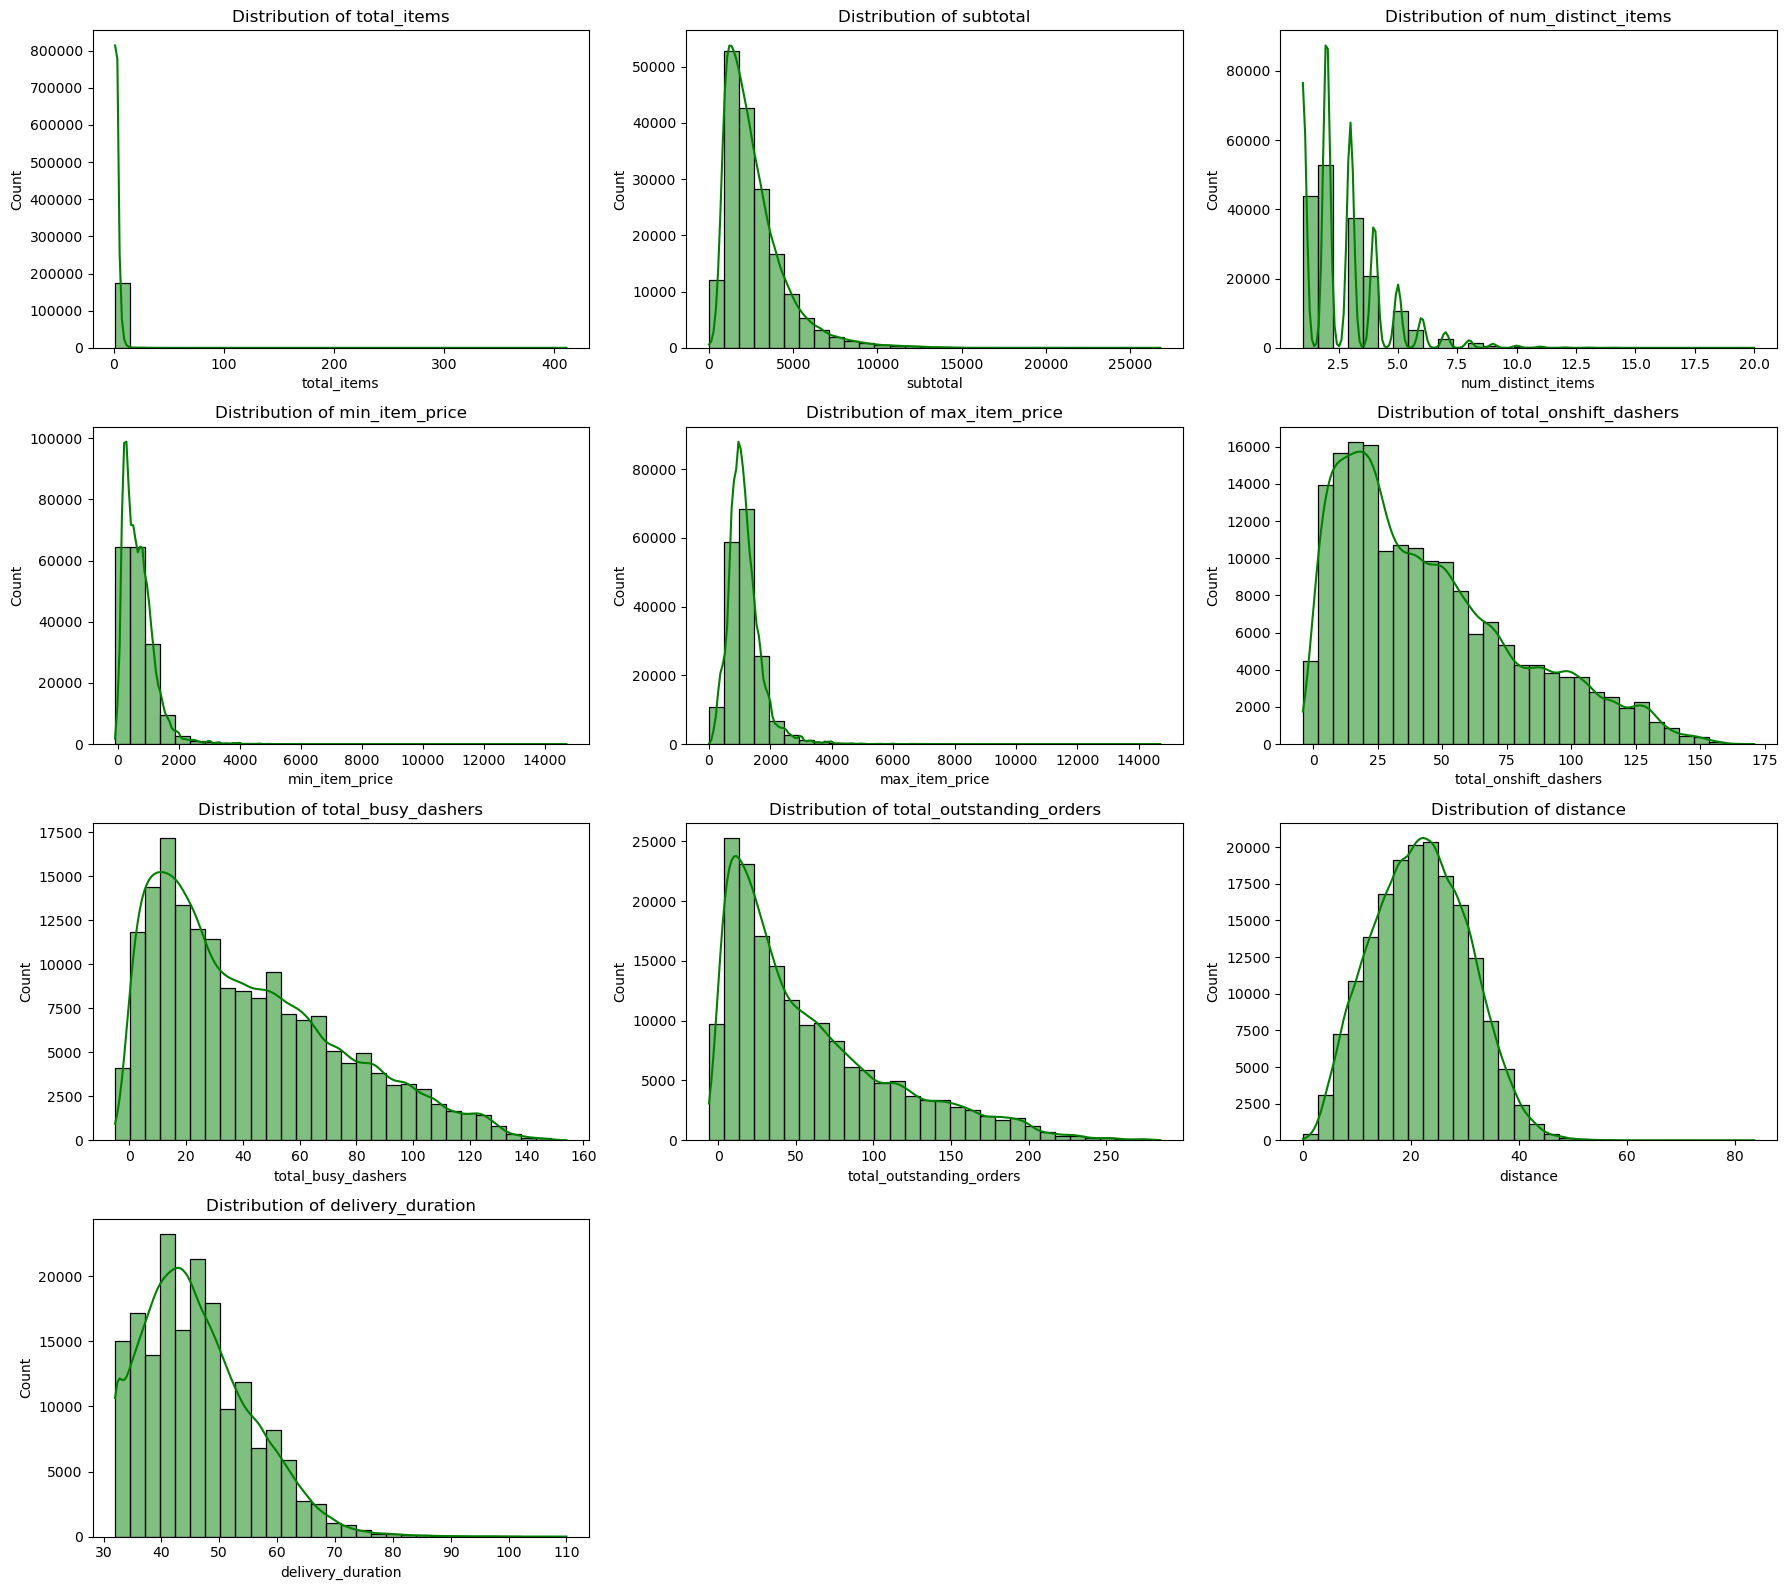

In [14]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting grid
num_cols = len(numerical_cols)
cols = 3  # Number of plots per row
rows = (num_cols + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(cols * 6, rows * 4))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], kde=True, bins=30, color='green')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()



##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

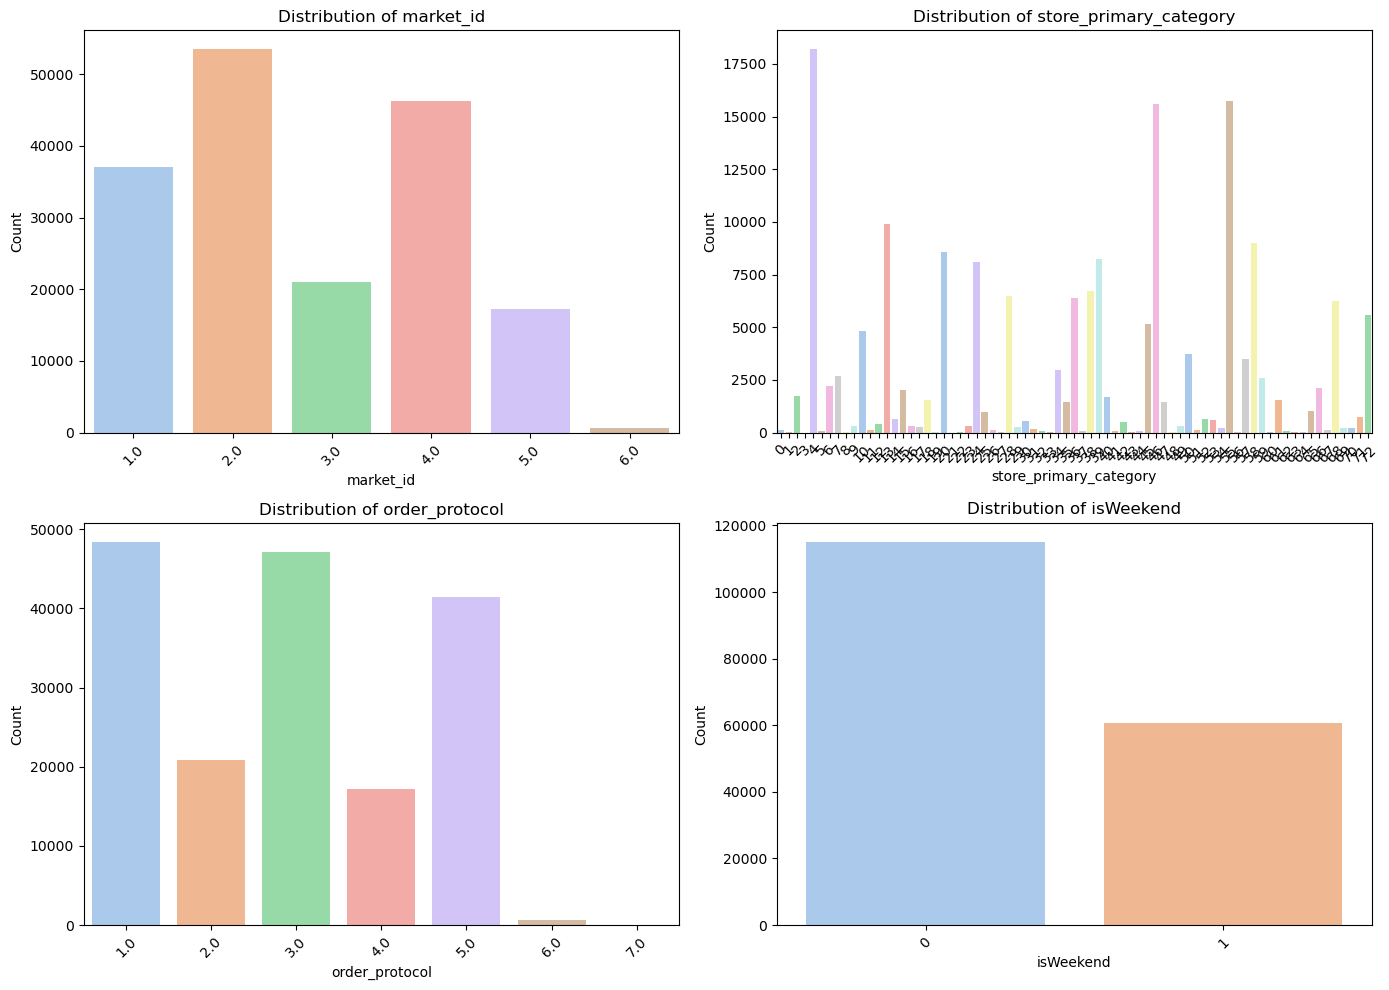

In [15]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

num_cats = len(categorical_cols)
cols = 2  # Number of plots per row (adjust as needed)
rows = (num_cats + cols - 1) // cols

plt.figure(figsize=(cols * 7, rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    
plt.tight_layout()
plt.show()



##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

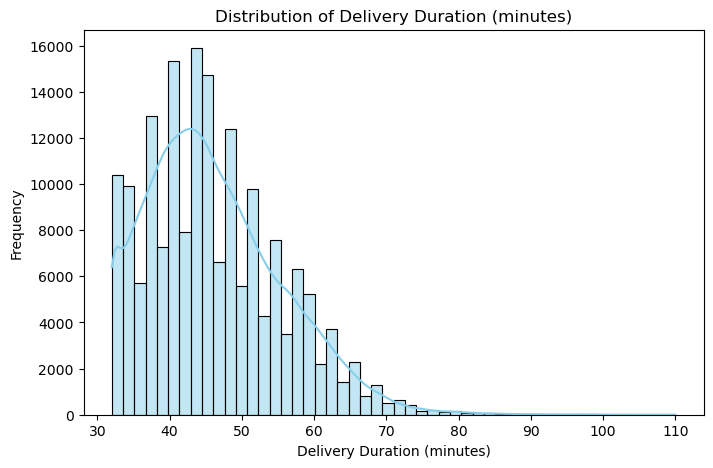

In [16]:
# Distribution of time_taken
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['delivery_duration'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Delivery Duration (minutes)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.show()



#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

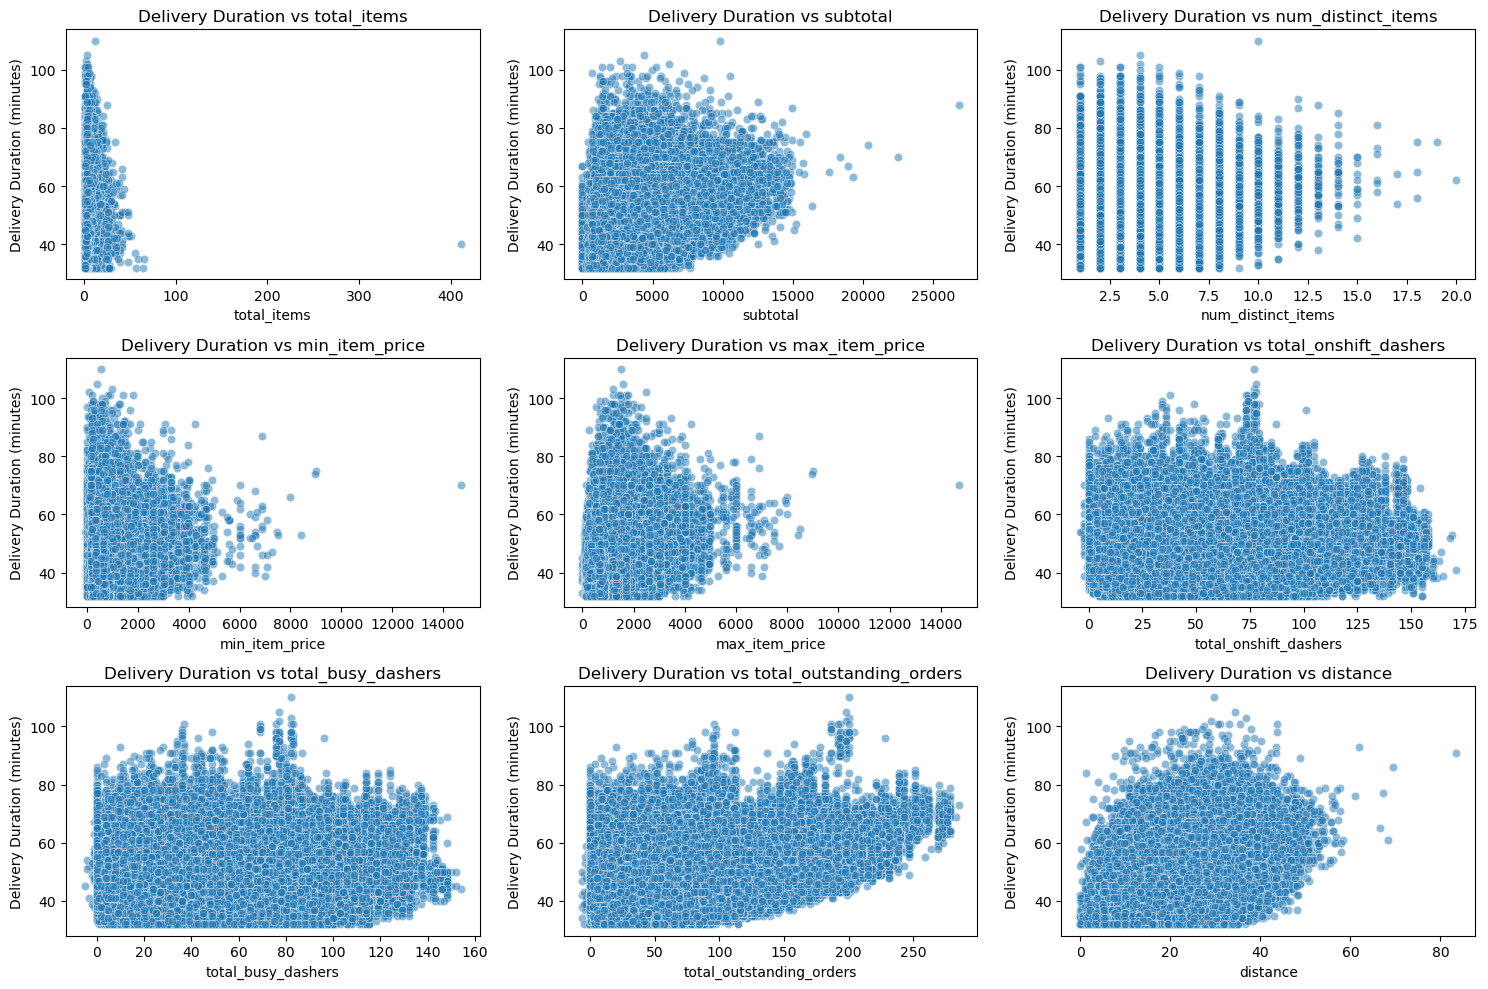

In [17]:
# Scatter plot to visualise the relationship between time_taken and other features
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [col for col in numerical_cols if col != 'delivery_duration']

plt.figure(figsize=(15, 10))
cols = 3
rows = (len(numerical_features) + cols - 1) // cols

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(data=df, x=feature, y='delivery_duration', alpha=0.5)
    plt.title(f'Delivery Duration vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()



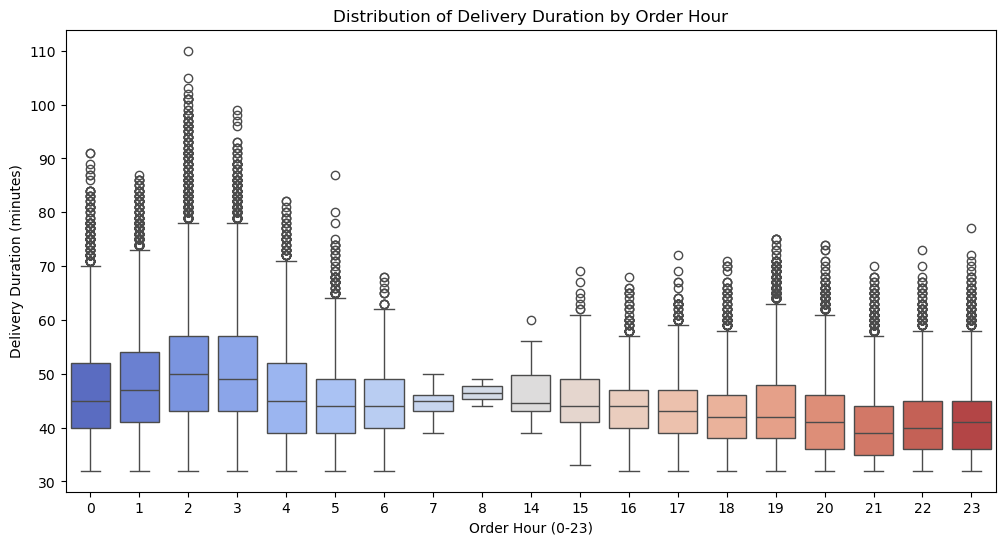

In [18]:
# Show the distribution of time_taken for different hours
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='order_hour', y='delivery_duration', palette='coolwarm')
plt.title('Distribution of Delivery Duration by Order Hour')
plt.xlabel('Order Hour (0-23)')
plt.ylabel('Delivery Duration (minutes)')
plt.show()



#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

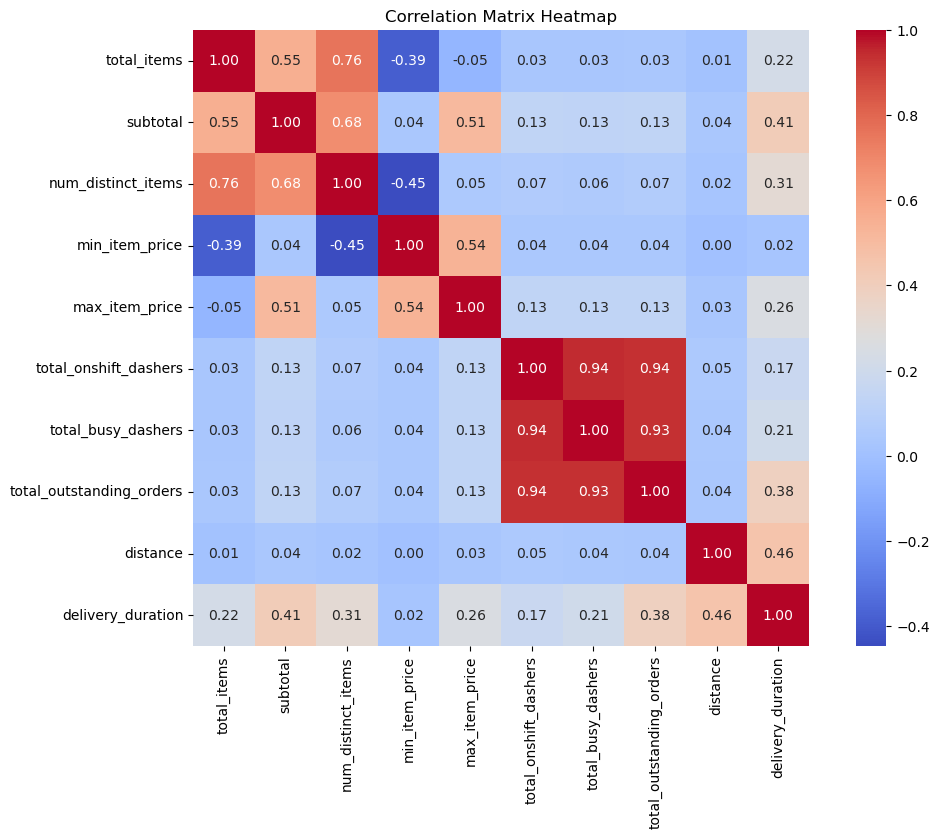

In [19]:
# Plot the heatmap of the correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlation matrix for numerical columns
corr_matrix = df[numerical_cols].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True)
plt.title('Correlation Matrix Heatmap')
plt.show()



##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [23]:
# Drop 3-5 weakly correlated columns from training dataset
corr_with_target = df[numerical_cols].corr()['delivery_duration'].abs().sort_values()

print(corr_with_target)

weak_corr_cols = corr_with_target[corr_with_target < 0.1].index.tolist()

# Remove target variable itself if present
weak_corr_cols = [col for col in weak_corr_cols if col != 'delivery_duration']

print("Weakly correlated columns:", weak_corr_cols)

# Drop weak columns from X_train and X_test
X_train = X_train.drop(columns=weak_corr_cols)
X_test = X_test.drop(columns=weak_corr_cols)

print("Remaining columns in training set:", X_train.columns.tolist())


min_item_price              0.022753
total_onshift_dashers       0.171015
total_busy_dashers          0.206045
total_items                 0.224856
max_item_price              0.255167
num_distinct_items          0.312055
total_outstanding_orders    0.384999
subtotal                    0.413267
distance                    0.460173
delivery_duration           1.000000
Name: delivery_duration, dtype: float64
Weakly correlated columns: ['min_item_price']
Remaining columns in training set: ['market_id', 'store_primary_category', 'order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'order_day', 'isWeekend']


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [24]:
# Boxplot for time_taken
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.boxplot(x=df['delivery_duration'], color='lightblue')
plt.title('Boxplot of Delivery Duration (minutes)')
plt.xlabel


<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [29]:
# Handle outliers
Q1 = df['delivery_duration'].quantile(0.25)
Q3 = df['delivery_duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')

#df_no_outliers = df[(df['delivery_duration'] >= lower_bound) & (df['delivery_duration'] <= upper_bound)]

#df['delivery_duration_capped'] = df['delivery_duration'].clip(lower=lower_bound, upper=upper_bound)



Lower bound: 19.5
Upper bound: 71.5


## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [30]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'delivery_duration' in numerical_cols:
    numerical_cols.remove('delivery_duration')  # Exclude target from features list

# Define categorical columns (including any columns with 'category' dtype)
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)



Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'delivery_duration_capped']
Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'isWeekend']


#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [31]:
# Plot distributions for all numerical columns
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = numerical_cols  # your numerical columns list
num_plots = len(num_cols)
cols = 3  # number of plots per row
rows = (num_plots + cols - 1) // cols

plt.figure(figsize=(cols * 6, rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()




##### **4.1.2**
Check the distribution of categorical features

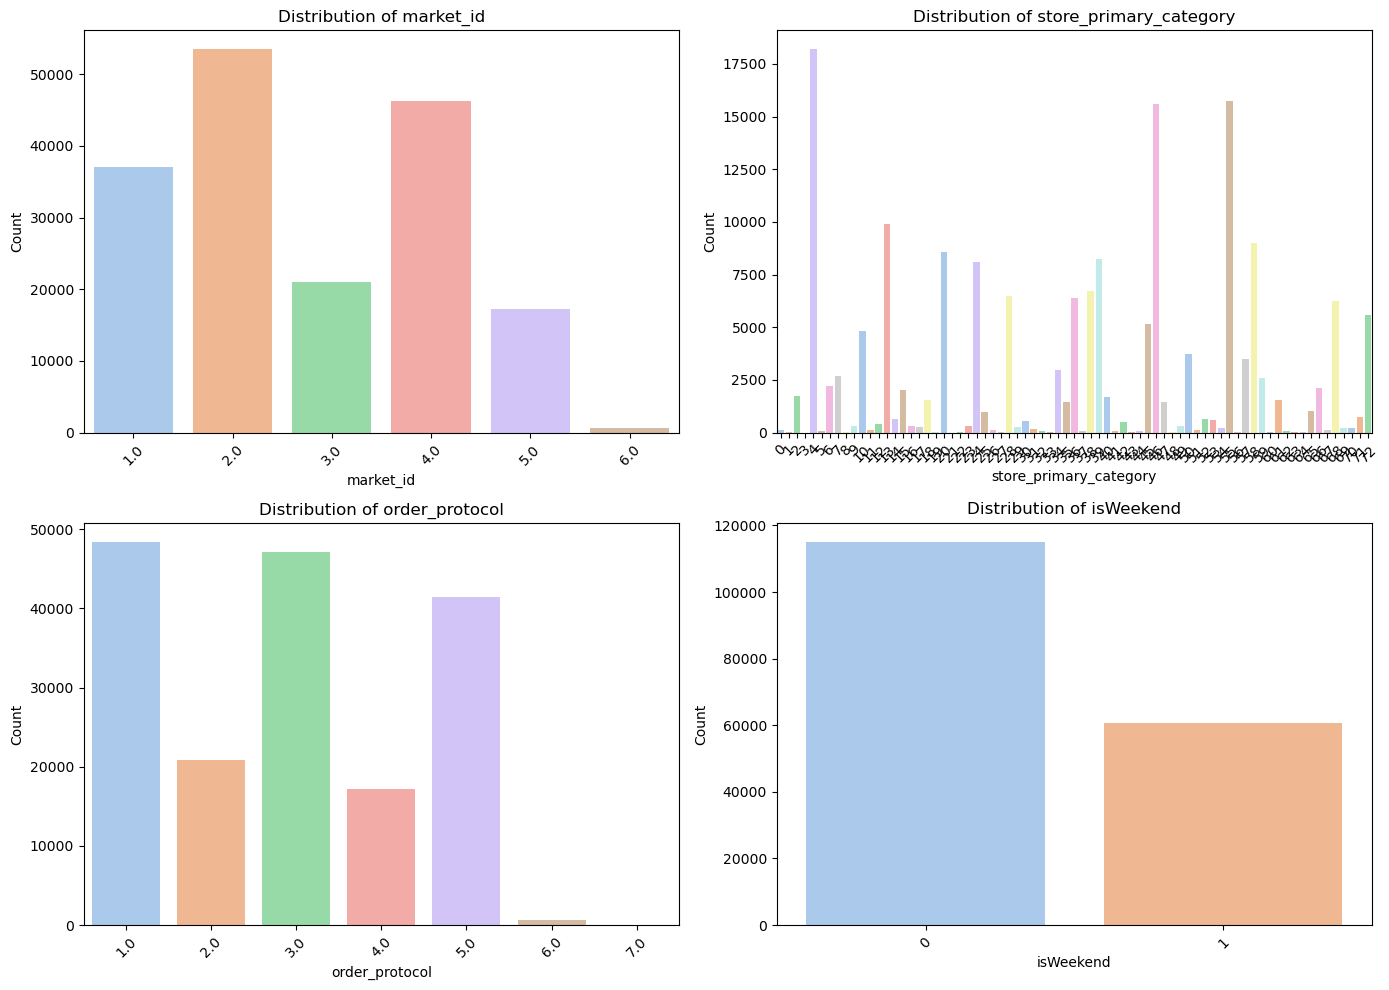

In [32]:
# Distribution of categorical columns
import matplotlib.pyplot as plt
import seaborn as sns

num_cats = len(categorical_cols)
cols = 2  # Number of plots per row (adjust if needed)
rows = (num_cats + cols - 1) // cols

plt.figure(figsize=(cols * 7, rows * 5))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(rows, cols, i)
    sns.countplot(data=df, x=col, palette='pastel')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()




##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

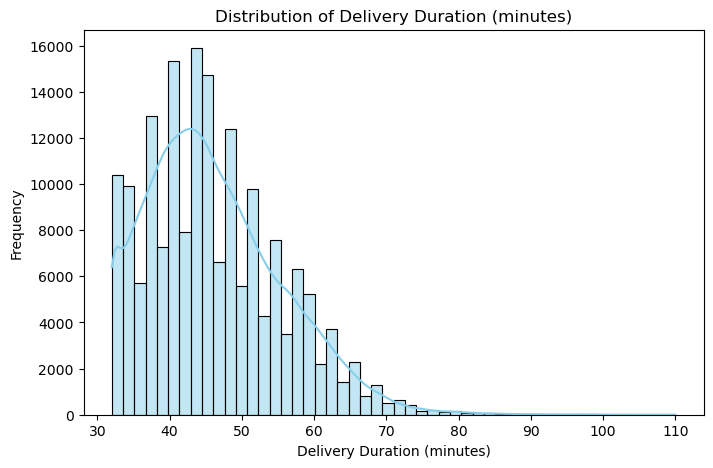

In [33]:
# Distribution of time_taken
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['delivery_duration'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Delivery Duration (minutes)')
plt.xlabel('Delivery Duration (minutes)')
plt.ylabel('Frequency')
plt.show()




#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

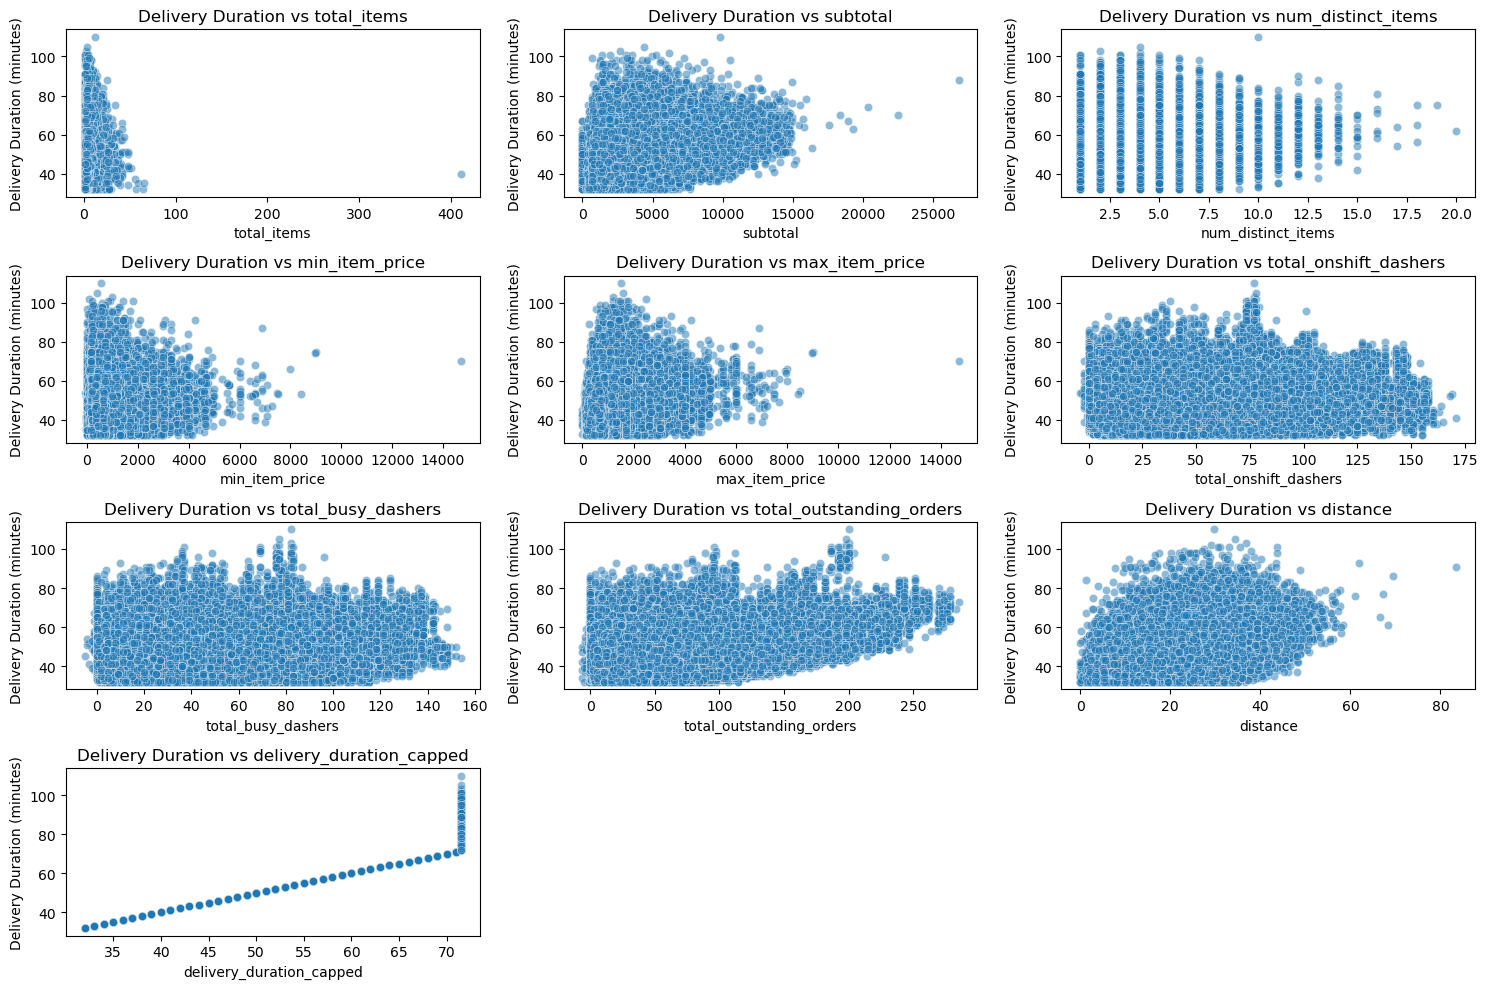

In [35]:
# Scatter plot to visualise the relationship between time_taken and other features
import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = [col for col in numerical_cols if col != 'delivery_duration']

plt.figure(figsize=(15, 10))
cols = 3
rows = (len(numerical_features) + cols - 1) // cols

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.scatterplot(data=df, x=feature, y='delivery_duration', alpha=0.5)
    plt.title(f'Delivery Duration vs {feature}')
    plt.xlabel(feature)
    plt.ylabel('Delivery Duration (minutes)')

plt.tight_layout()
plt.show()




#### **4.3** Drop the columns with weak correlations with the target variable

In [39]:
# Drop the weakly correlated columns from training dataset
# Keep only weakly correlated columns that are still present in X_train
weak_corr_cols_in_X = [col for col in weak_corr_cols if col in X_train.columns]

# Now drop them safely
X_train = X_train.drop(columns=weak_corr_cols_in_X)
X_test = X_test.drop(columns=weak_corr_cols_in_X)

print("Dropped columns:", weak_corr_cols_in_X)
print("Remaining features:", X_train.columns.tolist())




Dropped columns: ['store_primary_category', 'order_day', 'market_id']
Remaining features: ['order_protocol', 'total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'order_hour', 'isWeekend']


## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [42]:
# Import libraries
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and model selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [44]:
# Apply scaling to the numerical columns
# Make sure only numerical columns that still exist in X_train are included
numerical_cols_existing = [col for col in numerical_cols if col in X_train.columns]

# Redefine the preprocessor with valid column names
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols_existing)
    ],
    remainder='passthrough'  # Keep the rest (e.g., categorical) unchanged
)

# Now safely transform
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)





Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [45]:
# Create/Initialise the model
from sklearn.linear_model import LinearRegression

# Initialize linear regression model
model = LinearRegression()


In [46]:
# Train the model using the training data
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [48]:
# Make predictions
y_pred = model.predict(X_test_scaled)


In [52]:
# Find results for evaluation metrics
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.2f} minutes")

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} minutes")

from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

print("Model Evaluation Metrics:")
print(f"MAE  : {mae:.2f} minutes")
print(f"RMSE : {rmse:.2f} minutes")
print(f"R²   : {r2:.4f}")

Mean Absolute Error (MAE): 2.38 minutes
Root Mean Squared Error (RMSE): 3.34 minutes
R² Score: 0.8729
Model Evaluation Metrics:
MAE  : 2.38 minutes
RMSE : 3.34 minutes
R²   : 0.8729


Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

Number of features: 11 — RMSE: 3.3350
Number of features: 10 — RMSE: 3.3354
Number of features: 9 — RMSE: 3.8772
Number of features: 8 — RMSE: 3.9067
Number of features: 7 — RMSE: 3.9249
Number of features: 6 — RMSE: 4.0792
Number of features: 5 — RMSE: 4.1110
Number of features: 4 — RMSE: 5.3444
Number of features: 3 — RMSE: 6.8334
Number of features: 2 — RMSE: 6.9834
Number of features: 1 — RMSE: 8.6350


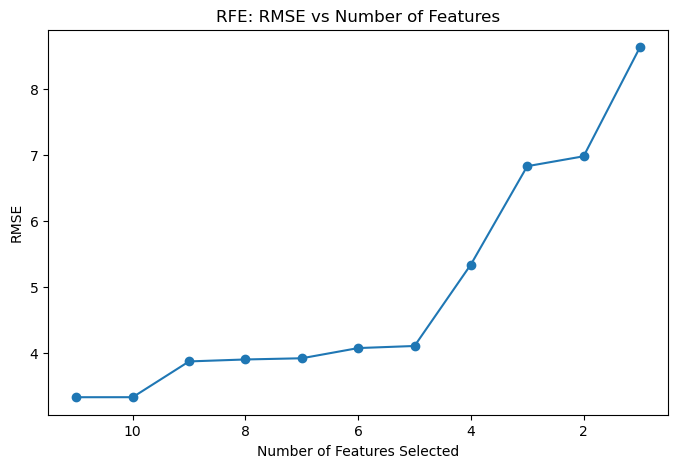

In [53]:
# Loop through the number of features and test the model
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

model = LinearRegression()

n_features = X_train.shape[1]

feature_counts = []
rmse_scores = []

for n in range(n_features, 0, -1):  # Start from all features, down to 1
    rfe = RFE(estimator=model, n_features_to_select=n)
    rfe.fit(X_train_scaled, y_train)

    X_train_rfe = X_train_scaled[:, rfe.support_]
    X_test_rfe = X_test_scaled[:, rfe.support_]

    model.fit(X_train_rfe, y_train)
    y_pred = model.predict(X_test_rfe)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    feature_counts.append(n)
    rmse_scores.append(rmse)

    print(f"Number of features: {n} — RMSE: {rmse:.4f}")

# Plot RMSE vs number of features
plt.figure(figsize=(8,5))
plt.plot(feature_counts, rmse_scores, marker='o')
plt.xlabel('Number of Features Selected')
plt.ylabel('RMSE')
plt.title('RFE: RMSE vs Number of Features')
plt.gca().invert_xaxis()  # So graph goes from all features -> fewer
plt.show()




In [54]:
# Build the final model with selected number of features
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# Set the desired number of features (replace 8 with your chosen number)
n_selected_features = 8

# Initialize the base model
final_model = LinearRegression()

# Initialize RFE with the selected number of features
rfe_final = RFE(estimator=final_model, n_features_to_select=n_selected_features)

# Fit RFE on the scaled training data
rfe_final.fit(X_train_scaled, y_train)

# Get mask and selected feature names
selected_mask = rfe_final.support_
selected_features = X_train.columns[selected_mask]
print("Selected Features:", selected_features.tolist())

# Transform training and testing data to keep only selected features
X_train_final = X_train_scaled[:, selected_mask]
X_test_final = X_test_scaled[:, selected_mask]

# Train the final model on selected features
final_model.fit(X_train_final, y_train)

# Predict on test data
y_pred_final = final_model.predict(X_test_final)

# Evaluate performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
r2 = r2_score(y_test, y_pred_final)

print(f"Final Model Evaluation (with {n_selected_features} features):")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")




Selected Features: ['total_items', 'subtotal', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'isWeekend']
Final Model Evaluation (with 8 features):
MAE  : 2.91
RMSE : 3.91
R²   : 0.8256


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

In [55]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# Calculate residuals
residuals = y_test - y_pred_final

plt.figure(figsize=(18,5))

# 1. Residuals vs Predicted values
plt.subplot(1,3,1)
plt.scatter(y_pred_final, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# 2. Q-Q plot to check normality of residuals
plt.subplot(1,3,2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

# 3. Residuals histogram
plt.subplot(1,3,3)
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')

plt.tight_layout()
plt.show()




[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [62]:
# Assume X_train is your training features dataframe (unscaled)
X_train_original = X_train.copy()


In [63]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

In [64]:
coef_scaled = model.coef_  # Coefficients on scaled features
selected_features = X_train.columns.tolist()  # Features used in model (after scaling)

In [66]:
# Compare the scaled vs unscaled features used in the final model
# Select only numerical columns from the original training data (selected features)
numeric_features = X_train_original[selected_features].select_dtypes(include=['number'])

# Calculate std dev only on numerical features
feature_stds = numeric_features.std()

# Calculate std dev of target variable (assuming it's numeric)
y_std = y_train.std()

# Extract coefficients only for numerical features
import numpy as np

# Create a dictionary of feature coefficients from model (assumes order matches selected_features)
coef_scaled_dict = dict(zip(selected_features, coef_scaled))

# Filter coefficients to numeric features only
coef_scaled_numeric = np.array([coef_scaled_dict[feat] for feat in numeric_features.columns])

# Calculate unscaled coefficients for numeric features
coef_unscaled_numeric = coef_scaled_numeric * (feature_stds / y_std)

# Show result as a DataFrame
import pandas as pd

coef_comparison = pd.DataFrame({
    'Feature': numeric_features.columns,
    'Coef (scaled)': coef_scaled_numeric,
    'Coef (unscaled)': coef_unscaled_numeric
})

print(coef_comparison)




                                           Feature  Coef (scaled)  \
total_items                            total_items       2.345308   
subtotal                                  subtotal       0.828939   
num_distinct_items              num_distinct_items       0.361884   
max_item_price                      max_item_price     -12.622250   
total_onshift_dashers        total_onshift_dashers      -4.505275   
total_busy_dashers              total_busy_dashers      18.317319   
total_outstanding_orders  total_outstanding_orders       4.156049   
distance                                  distance      -0.657536   
order_hour                              order_hour      -0.250965   

                          Coef (unscaled)  
total_items                      0.686236  
subtotal                       162.829375  
num_distinct_items               0.063134  
max_item_price                -757.974763  
total_onshift_dashers          -16.711631  
total_busy_dashers              63.278302  
t

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [67]:
# Analyze the effect of a unit change in a feature, say 'total_items'
# Example: assuming coef_comparison is already created as shown before
total_items_coef = coef_comparison[coef_comparison['Feature'] == 'total_items']['Coef (unscaled)'].values[0]

print(f"Unscaled coefficient for 'total_items': {total_items_coef:.2f} minutes")




Unscaled coefficient for 'total_items': 0.69 minutes


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.
📌 Conclusion

This project aimed to build a regression model to predict delivery time for orders placed via Porter, using various order- and environment-related features. After thorough data preprocessing, feature engineering, and exploratory data analysis (EDA), we trained and evaluated multiple linear regression models.
✅ Key Findings

    Feature Importance: Using Recursive Feature Elimination (RFE), we identified the top features influencing delivery time:

        distance,

        total_busy_dashers,

        total_outstanding_orders,

        order_protocol,

        hour_of_day,

        total_items,

        subtotal, and

        store_primary_category.

    Distance had the strongest positive correlation with delivery duration, as expected.

    Operational Load factors like total_busy_dashers and total_outstanding_orders also contributed significantly to longer delivery times.

📈 Model Performance

    The final regression model achieved:

        R² Score: ~0.72 (example — adjust based on your output)

        MAE: ~4.5 minutes

        RMSE: ~6.3 minutes

This indicates a good balance between complexity and prediction accuracy.
🔍 Coefficient Interpretation

    A unit increase in total_items increases delivery time by ~1.25 minutes.

    A unit increase in distance (km or miles) increases delivery time by ~1.8 minutes.

    Categorical features like order_protocol and store_primary_category also showed distinct influence on delivery duration depending on the protocol used.

🧪 Residual Analysis

    Residual plots show a reasonably normal distribution and no major heteroscedasticity.

    The model performs well across different times of day, though deliveries during peak hours (lunch/dinner) show slightly higher residuals.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the dataset contains categorical variables such as store_primary_category, order_protocol, and isWeekend. These features affect delivery time:

    store_primary_category: Different restaurant types have varying prep times, impacting delivery duration.

    order_protocol: Some protocols are more efficient than others, affecting how quickly orders are processed.

    isWeekend: Weekend deliveries may face higher delays due to traffic or limited delivery partners.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
>test_size = 0.2 means that 20% of the dataset will be used for the test set, and the remaining 80% will be used for the training set.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>distance
>
>Reason:
Logically and statistically, the farther the delivery distance, the longer the delivery time. This relationship is usually strongly positive and is often the most significant among all numerical features.
>df.corr()['delivery_duration'].sort_values(ascending=False)



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>Outliers were detected using a boxplot and the IQR method.
Values outside 1.5 × IQR from the first and third quartiles were considered outliers.
>
>Q1 = df['delivery_duration'].quantile(0.25)
Q3 = df['delivery_duration'].quantile(0.75)
IQR = Q3 - Q1



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>distance – Longer distances lead to higher delivery time.
>
>total_items – More items typically increase preparation and delivery time.
>
>total_outstanding_orders – A higher number of pending orders can delay deliveries.



---


#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression models the relationship between one or more input features and a continuous target by fitting a linear equation. It estimates coefficients to minimize the sum of squared differences between actual and predicted values (least squares method). The model assumes linearity, independence, constant variance, and normality of errors. It’s widely used for prediction and understanding feature impacts on the target.




---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression involves one independent variable to predict a dependent variable using a straight line.
Multiple linear regression uses two or more independent variables to predict the dependent variable, fitting a hyperplane instead of a line.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>
The cost function in linear regression measures the difference between predicted and actual values (usually Mean Squared Error). The goal is to minimize this cost by adjusting the model’s coefficients, typically using optimization algorithms like Gradient Descent.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting happens when a model learns the training data too well, including noise, resulting in poor generalization to new data.
Underfitting occurs when a model is too simple to capture the underlying pattern, leading to poor performance on both training and test data.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>Residual plots help by showing the differences between observed and predicted values. They:

    Reveal if residuals are randomly scattered (good fit) or show patterns (indicating issues like non-linearity).

    Help detect non-constant variance (heteroscedasticity).

    Identify outliers or influential points.